<h1 align="center">Deep Learning - Master in Deep Learning of UPM</h1> 

**IMPORTANTE**

Antes de empezar debemos instalar PyTorch Lightning, por defecto, esto valdría:

In [ ]:
!pip install pytorch-lightning

Además, si te encuentras ejecutando este código en Google Collab, lo mejor será que montes tu drive para tener acceso a los datos:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import datetime

import torch
import torch.nn as nn

import pytorch_lightning
import torchmetrics
from pytorch_lightning import seed_everything

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


DATA_PATH = 'data/stocks.csv'
SEED = 42
seed_everything(seed=SEED) # Fijamos una semilla para reproducibilidad en los experimentos

Seed set to 42


42

Ya sabemos como atacar mediante el uso de Redes Neuronales Recurrentes un problema univariable de series temporales. En este ejercicio práctico subiremos algo el nivel enfrentándonos a un clásico problema de stock prediction. Utilizaremos técnicas similares para predecir el valor futuro de diversas acciones.

Nuestra variable objetivo será el precio de cierre de cierta acción en el futuro (Close). Como ya hemos visto, en series temporales, la misma variable puede ser a la vez inputs y etiquetas, siempre y cuando difieran temporalmente.

In [23]:
df = pd.read_csv(DATA_PATH)

df.head() # Imprimamos las primeras filas del dataframe

,date,close
0,03/01/2006,47.58
1,04/01/2006,47.25
2,05/01/2006,47.65
3,06/01/2006,47.87
4,09/01/2006,47.08


Este dataset consta del precio de cierre de la acción de Amazon (AMZN) desde 2006 hasta 2017.

In [25]:
data = pd.read_csv(DATA_PATH)

data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data.sort_values('date', inplace=True)
print(f"Date range: {data['date'].min()} to {data['date'].max()}")

Date range: 2006-01-03 00:00:00 to 2017-12-29 00:00:00


Construye un Dataset que reciba el tamaño de ventana y de horizonte

In [43]:
class StocksDataset(torch.utils.data.Dataset):
    def __init__(self, df, w=10, h=1):
        self.data = df.drop('date', axis=1).values
        self.w = w
        self.h = h

    def __len__(self):
        return len(self.data) - (self.w + self.h) + 1

    def __getitem__(self, idx):
        features = self.data[idx:idx+self.w] # [i: i+w)
        target = self.data[idx+self.w: idx+self.w+self.h].reshape(-1) # [i+w, i+w+h)
        return features, target # (w, input_size), (h,)

Para seguir, el siguiente código no debe dar error ninguno

In [44]:
w = 10
h = 3
input_size = 1 # Univariable

df = pd.read_csv(DATA_PATH)
dataset = StocksDataset(df, w=w, h=h)

sample = dataset[0]

assert len(sample) == 2 # Comprobamos que el dataset devuelve dos elementos
assert sample[0].shape == (w, input_size) # Comprobamos que las features tienen la forma correcta
assert sample[1].shape == (h, ) # Comprobamos que el target tiene la forma correcta

Antes de saltar al DataModule, tenemos que tener en cuenta la distribución de la serie temporal a la hora de normalizar los datos.

<Axes: title={'center': 'AMZN stock price'}, xlabel='Date', ylabel='Price'>

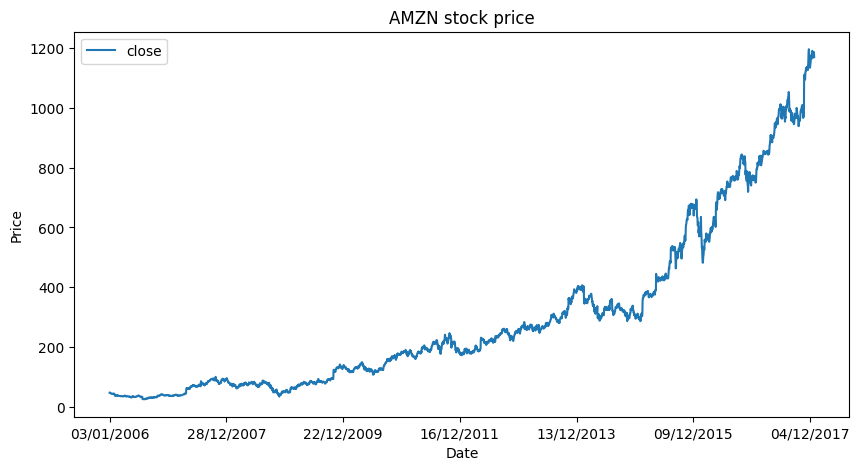

In [108]:
data = pd.read_csv(DATA_PATH)
data.plot(x='date', y='close', title='AMZN stock price', ylabel='Price', xlabel='Date', figsize=(10, 5))

Si hacemos MinMax el valor máximo del train (valores más tempranos temporalmente) será muy inferior a los valores máximos del test (futuro). Pudiendo pasar algo como esto:

![incorrect_norm_time_series](../../../utils/incorrect_norm_time_series.png)

Una forma de evitar esto es utilizar un escalador por cada uno de los splits, esto es algo que deberéis tener en cuenta al hacer la normalización.

Ya podemos crear el DataModule

In [117]:
class StocksDataModule(pytorch_lightning.LightningDataModule):
    def __init__(self, df, w=10, h=1, batch_size=16, val_size=0.2, test_size=0.2):
        super().__init__()
        self.data = df

        self.sequential_train_val_test_split(df, val_size=val_size, test_size=test_size)
        self.normalize()

        self.w = w
        self.h = h

        self.batch_size = batch_size

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = StocksDataset(self.train_df, w=self.w, h=self.h)
            self.val_dataset = StocksDataset(self.val_df, w=self.w, h=self.h)
        elif stage == 'test':
            self.test_dataset = StocksDataset(self.test_df, w=self.w, h=self.h)
    
    def normalize(self):
        self.scaler_train = MinMaxScaler()
        self.scaler_val = MinMaxScaler()
        self.scaler_test = MinMaxScaler()

        # Ajusta y transforma cada split
        self.train_df['close'] = self.scaler_train.fit_transform(self.train_df[['close']])
        self.val_df['close'] = self.scaler_val.fit_transform(self.val_df[['close']])
        self.test_df['close'] = self.scaler_test.fit_transform(self.test_df[['close']])

    def sequential_train_val_test_split(self, df, val_size=0.2, test_size=0.2):
        # Aseguramos el formato de la fecha y ordenamos por ella
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
        df.sort_values('date', inplace=True)

        # Calculamos los índices para hacer los splits
        n = len(df)
        train_end = int((1 - val_size - test_size) * n)
        val_end = int((1 - test_size) * n)

        self.train_df = df.iloc[:train_end].copy()
        self.val_df = df.iloc[train_end:val_end].copy()
        self.test_df = df.iloc[val_end:].copy()
    
    def collate_fn(self, batch):
        features, targets = zip(*batch)

        features = np.stack(features, axis=0)  # [batch_size, w, input_size]
        targets = np.stack(targets, axis=0)    # [batch_size, h, input_size]

        features = torch.tensor(features, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)
        return features, targets
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)

A continuación creemos nuestro modelo de regresión temporal basado en una RNN. La diferencia con el que hemos aprendido en clase será que este reciba un argumento extra _pooling_[str] que podrá tomar tres valores y actuar en consecuencia:

- _pooling_ = "last" -> tomará la última salida de la RNN
- _pooling_ = "mean" -> realizará las medias a lo largo del eje temporal
- _pooling_ = "max" -> computará el máximo en la dimensión temporal

Sea cual sea la dimensión de salida no deberá variar

In [46]:
class RNNRegressor(nn.Module):
    """
    RNN Regressor model
    h[int]: horizonte de predicción
    input_size[int]: variables de la serie temporal
    hidden_size[int]: tamaño de las capas ocultas de la RNN
    num_layers[int]: número de capas de la RNN (si > 1, stacking de células RNN)
    batch_first[bool]: si el batch_size es la primera dimensión
    p_drop[float]: probabilidad de dropout
    pooling[str]: tipo de pooling a realizar sobre las salidas de la RNN
    """
    def __init__(self, h=1, input_size=1, hidden_size=64, num_layers=1, batch_first=True, p_drop=0.0, pooling='last'):
        super().__init__()
        self.pooling = pooling
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, dropout=p_drop)
        self.out = nn.Linear(hidden_size, h)
    
    def forward(self, x):
        outputs, _ = self.rnn(x) # [batch_size, seq_len, input_size] -> [batch_size, seq_len, hidden_size]
        match self.pooling:
            case 'last': # Última salida de la RNN
                pooled = outputs[:, -1, :]
            case 'mean': # Media de las salidas de la RNN
                pooled = outputs.mean(dim=1)
            case 'max': # Máximo de las salidas de la RNN
                pooled = torch.max(outputs, dim=1)

        return self.out(pooled) # [batch_size, hidden_size] -> [batch_size, 1]

Creemos el LightningModule

In [98]:
class StockPredictor(pytorch_lightning.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters() # guardamos la configuración de hiperparámetros
        self.learning_rate = learning_rate

        self.model = model

        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
    
    def compute_batch(self, batch, split='train'):
        inputs, targets = batch
        output = self(inputs)

        preds = output.view(-1)
        targets = targets.view(-1)

        loss = self.criterion(preds, targets)
        self.log_dict(
            {
                f'{split}_loss': loss, 
            }, 
            on_epoch=True, prog_bar=True)
            
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'val')
    
    def test_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'test')
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate) # self.parameters() son los parámetros del modelo

Ejercicio opcional: programar un Callback que una vez acabe el entrenamiento muestre una gráfica (Matplotlib) de forecasting con el conjunto de test. PISTA: _on_test_end()_

In [154]:
class ForecastingCallback(pytorch_lightning.Callback):
    def on_test_end(self, trainer, pl_module):
        # Obtenemos el datamodule
        dm = trainer.datamodule

        all_preds = []
        all_targets = []

        # Iteramos sobre el test_dataloader
        with torch.no_grad():
            for batch in dm.test_dataloader():
                features, targets = batch
                # features: [batch_size, seq_len, input_size]
                # targets: [batch_size, horizon] (o [batch_size] si es un horizonte 1)
                features = features.to(pl_module.device)
                targets = targets.to(pl_module.device)
                
                preds = pl_module(features)  # [batch_size, horizon] o [batch_size]
                
                # Guardamos predicciones y targets
                all_preds.append(preds.cpu())
                all_targets.append(targets.cpu())

        # Concatenamos todos los batch para tener un solo tensor
        # Si es horizonte > 1, puedes elegir un paso en particular o hacer promedio
        # Ej: tomamos el primer paso:
        all_preds = torch.cat(all_preds, dim=0)[:, 0]
        all_targets = torch.cat(all_targets, dim=0)[:, 0]

        # Utilizamos el scaler inverso para obtener los valores originales
        # all_preds = dm.scaler_test.inverse_transform(all_preds.reshape(-1, 1)).flatten()
        # all_targets = dm.scaler_test.inverse_transform(all_targets.reshape(-1, 1)).flatten()

        # Ahora graficamos
        plt.figure(figsize=(10, 6))
        plt.plot(all_targets, label='Real')
        plt.plot(all_preds, label='Predicción')
        plt.title('Comparación de Predicción vs Real (Test)')
        plt.xlabel('Índice de muestra')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()

A entrenar!

In [ ]:
# Parámetros
SAVE_DIR = f'lightning_logs/sales/{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
w = 10
h = 10
input_size = 1
batch_size = 64
num_layers = 1
hidden_size = 128
learning_rate = 1e-3
p_drop = 0.2
pooling = 'last'

# DataModule
data = pd.read_csv(DATA_PATH)
data_module = StocksDataModule(data, w=w, h=h, batch_size=batch_size)

# Model 
model = RNNRegressor(h=h, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, p_drop=p_drop, pooling=pooling)

# LightningModule
module = StockPredictor(model, learning_rate=learning_rate)

# Callbacks
early_stopping_callback = pytorch_lightning.callbacks.EarlyStopping(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', 
    patience=5, # número de epochs sin mejora antes de parar
    verbose=False, # si queremos que muestre mensajes del estado del early stopping 
)
model_checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', # queremos minimizar la pérdida
    save_top_k=1, # guardamos solo el mejor modelo
    dirpath=SAVE_DIR, # directorio donde se guardan los modelos
    filename=f'best_model' # nombre del archivo
)

# Descomentar en función de si queremos o no el callback de forecasting
# forecasting_callback = ForecastingCallback()
# callbacks = [early_stopping_callback, model_checkpoint_callback, forecasting_callback]

callbacks = [early_stopping_callback, model_checkpoint_callback]

# Loggers
csv_logger = pytorch_lightning.loggers.CSVLogger(
    save_dir=SAVE_DIR,
    name='metrics',
    version=None
)

loggers = [csv_logger] # se pueden poner varios loggers (mirar documentación)

# Trainer
trainer = pytorch_lightning.Trainer(max_epochs=50, accelerator='gpu', devices=[0], callbacks=callbacks, logger=loggers)

trainer.fit(module, data_module)
results = trainer.test(module, data_module)